In [1]:
# Test migration history reconstruction on simulated data

import sys
import os

REPO_DIR = os.path.join(os.getcwd(), "../../")
os.chdir(REPO_DIR)
from src.lib.metient import *
import matplotlib
import torch
MACHINA_DATA_DIR = os.path.join(REPO_DIR, 'src/data/machina_sims')


NOTE: Redirects are currently not supported in Windows or MacOs.


CUDA GPU: False


In [4]:
custom_colors = [matplotlib.colors.to_hex(c) for c in ['limegreen', 'cornflowerblue', 'hotpink', 'grey', 'saddlebrown', 'darkorange', 'purple', 'red', 'black', 'black', 'black', 'black']]
def find_labelings_all_mutation_trees(cluster_fn, all_mut_trees_fn, ref_var_fn):
    idx_to_cluster_label = get_idx_to_cluster_label(cluster_fn, ignore_polytomies=True)
    data = get_adj_matrices_from_spruce_mutation_trees(all_mut_trees_fn, idx_to_cluster_label, is_sim_data=True)
    weights = Weights(data_fit=0.2, mig=10, comig=7, seed_site=5, reg=1, gen_dist=0.5)
    print_config = PrintConfig(visualize=True, verbose=False, viz_intermeds=False, k_best_trees=5, save_outputs=False)
    for tree_num, (adj_matrix, pruned_idx_to_label) in enumerate(data):
        print(f"Tree {tree_num}")
        T = torch.tensor(adj_matrix, dtype = torch.float32)
        ref_matrix, var_matrix, unique_sites= get_ref_var_matrices_from_machina_sim_data(ref_var_fn, pruned_idx_to_label, T)
        G = get_genetic_distance_matrix_from_adj_matrix(T, pruned_idx_to_label, ";")
        T_edges, labeling, G_edges, loss_info, time = get_migration_history(T, ref_matrix, var_matrix, unique_sites, 'P', pruned_idx_to_label,
                                                                            weights, print_config, None, f"tree{tree_num}", 
                                                                            G=G, max_iter=100, batch_size=16000, custom_colors=custom_colors, 
                                                                            weight_init_primary=True)

import pydot
from IPython.display import Image, display

def visualize_ground_truth(tree_fn, graph_fn):
    def view_pydot(pdot):
        plt = Image(pdot.create_png())
        display(plt)
    
    (graph,) = pydot.graph_from_dot_file(tree_fn)
    view_pydot(graph)

    (graph,) = pydot.graph_from_dot_file(graph_fn)
    view_pydot(graph)
        
        

Tree 0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:56<00:00,  1.76it/s]


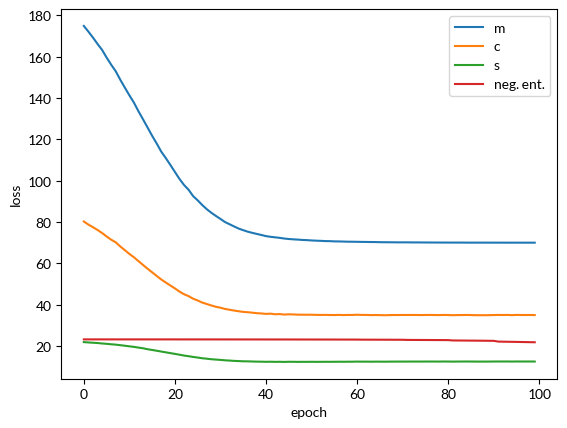

<Figure size 640x480 with 0 Axes>

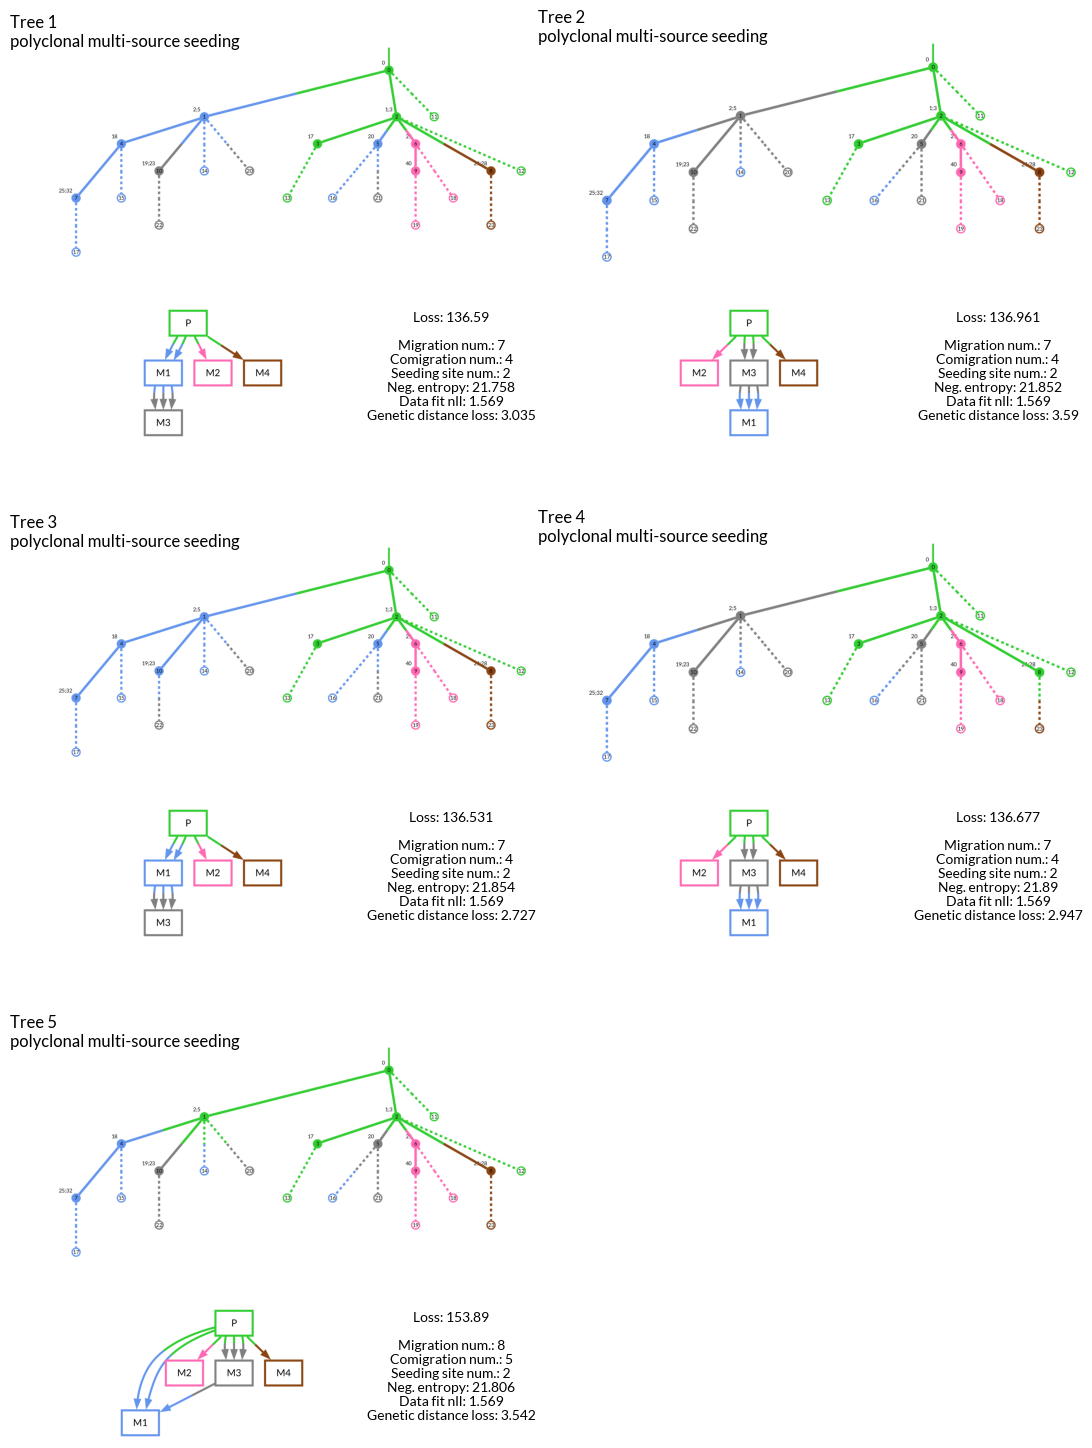

Tree 1


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:30<00:00,  1.10it/s]


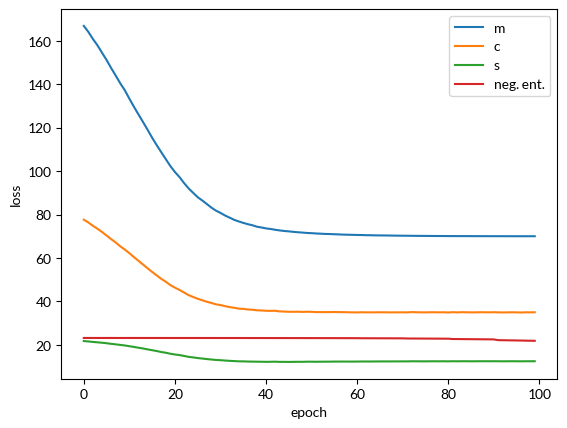

<Figure size 640x480 with 0 Axes>

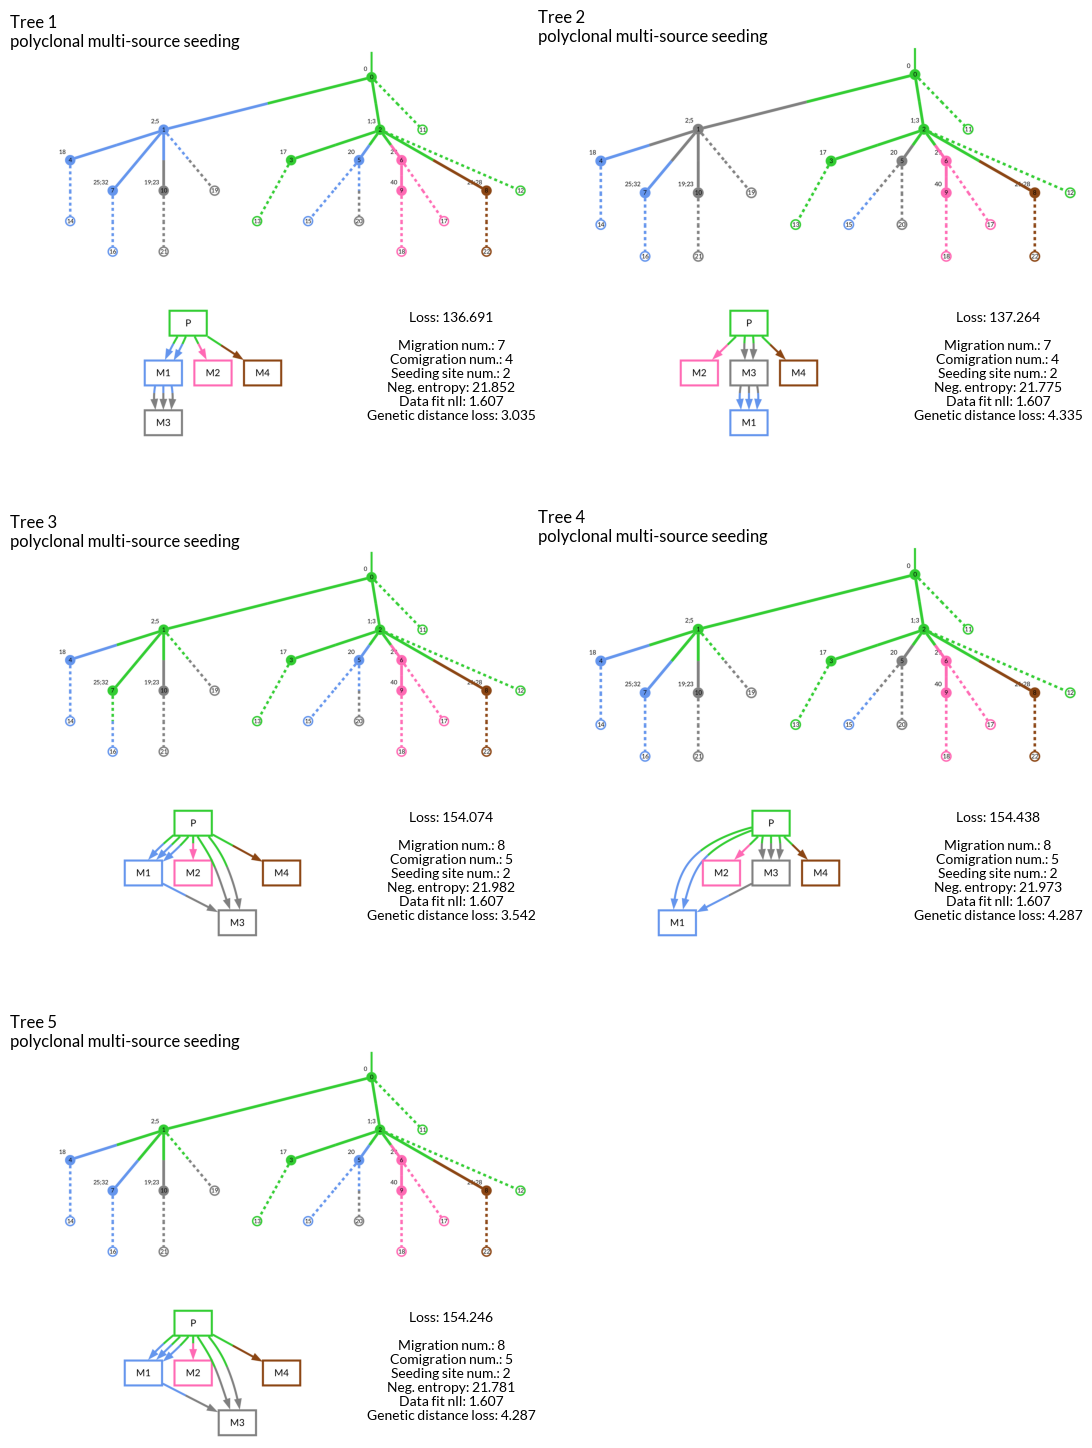

Tree 2


 29%|████████████████████████████████████▎                                                                                        | 29/100 [00:09<00:24,  2.90it/s]

KeyboardInterrupt



In [5]:
%%time
num_sites = "m5"
mig_type = "M"
seed = 565

find_labelings_all_mutation_trees(os.path.join(MACHINA_DATA_DIR, f"{num_sites}_clustered_input", f"cluster_{mig_type}_seed{seed}.txt"),
                                  os.path.join(MACHINA_DATA_DIR, f"{num_sites}_mut_trees", f"mut_trees_{mig_type}_seed{seed}.txt"),
                                  os.path.join(MACHINA_DATA_DIR, f"{num_sites}_clustered_input", f"cluster_{mig_type}_seed{seed}.tsv"))

Ground truth


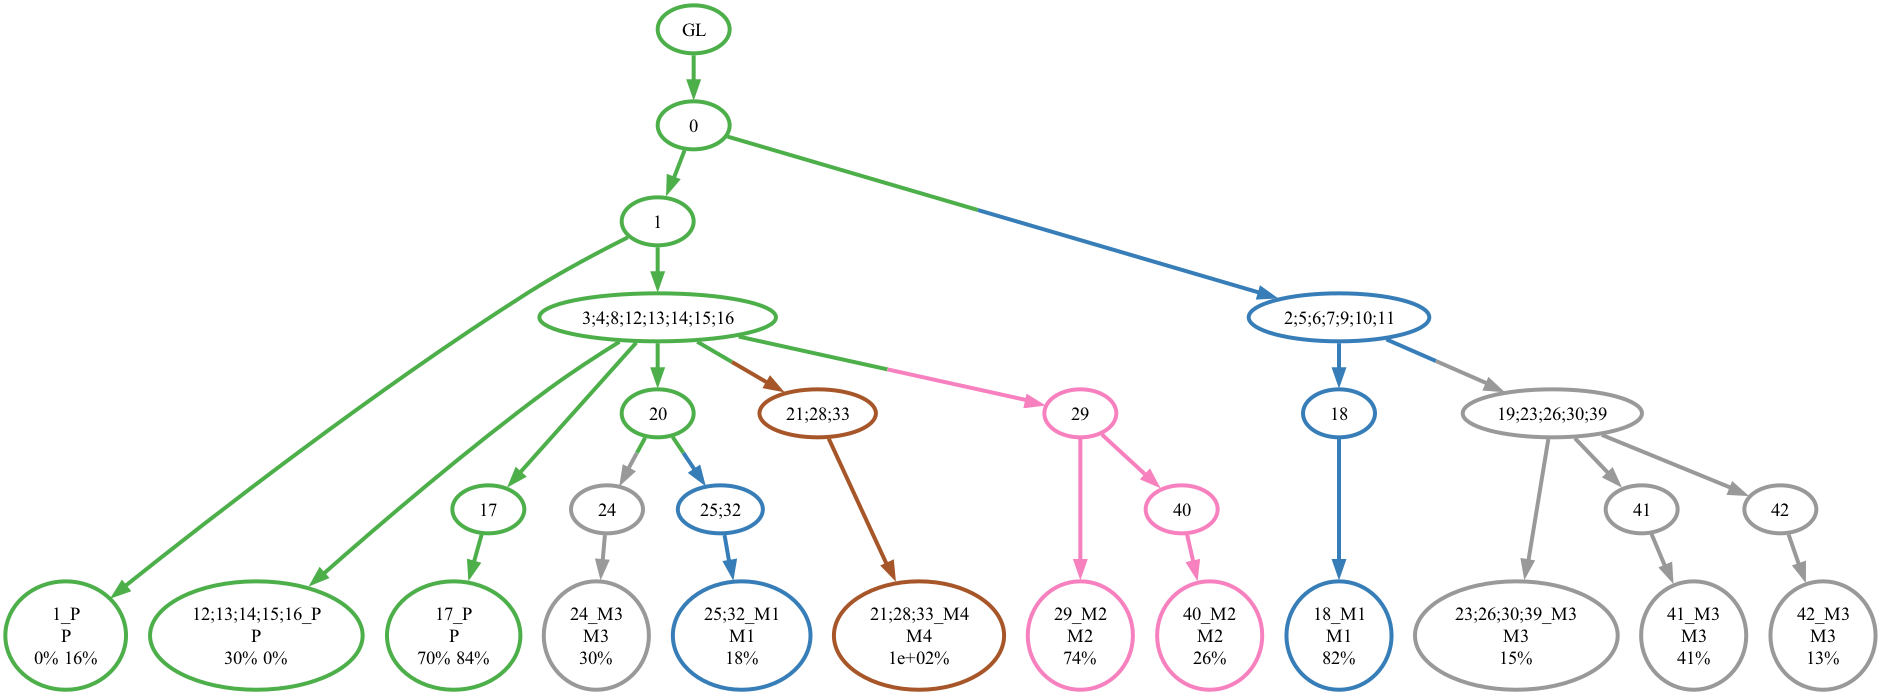

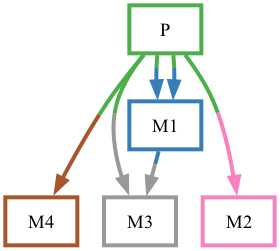

In [4]:
SIM_DATA_DIR = os.path.join(MACHINA_DATA_DIR, num_sites, mig_type)

print("Ground truth")
visualize_ground_truth(os.path.join(SIM_DATA_DIR, f"T_seed{seed}.dot"), os.path.join(SIM_DATA_DIR, f"G_seed{seed}.dot"))


tree > 50 trees m8 M 172 180
m8 M 314
tree > 50 trees m8 mS 12 108
m8 mS 138
m8 R 166
tree > 50 trees m8 S 2 144
tree > 50 trees m8 S 0 192
tree > 50 trees m8 S 31 60
m8 S 443
tree > 50 trees m5 M 473 80
m5 M 184
m5 mS 33
tree > 50 trees m5 R 2155 120
tree > 50 trees m5 R 247 78
m5 R 286
m5 S 83
[4, 6, 6, 2, 180, 12, 6, 48, 48, 2, 1, 8, 2, 8, 2, 2, 4, 108, 1, 2, 8, 20, 2, 2, 10, 48, 16, 32, 12, 16, 6, 144, 192, 6, 4, 4, 24, 60, 2, 1, 4, 4, 12, 80, 2, 30, 8, 24, 12, 8, 1, 3, 2, 4, 4, 2, 2, 2, 1, 12, 4, 2, 8, 8, 12, 48, 4, 2, 120, 78, 4, 4, 1, 2, 1, 4, 36, 4, 12, 15]


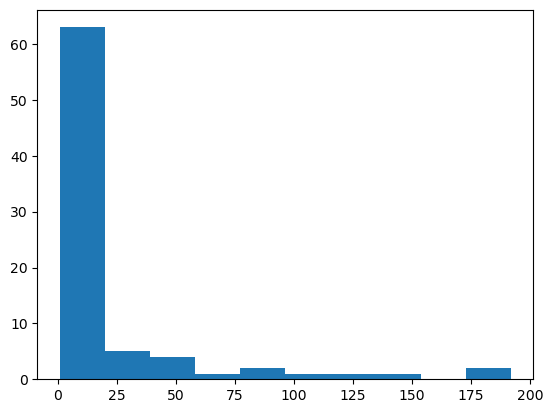

Number of total trees: 1647


In [6]:
import fnmatch
import matplotlib.pyplot as plt
def count_trees(sims_data_dir):
    sites = ["m8", "m5"]
    mig_types = ["M", "mS", "R", "S"]
    tree_cts = []
    ct = 0
    seed_ct = 0
    for site in sites:
        for mig_type in mig_types:
            local_ct = 0
            site_mig_data_dir = os.path.join(sims_data_dir, site, mig_type)
            seeds = fnmatch.filter(os.listdir(site_mig_data_dir), 'reads_seed*.tsv')
            seeds = [s.replace(".tsv", "").replace("reads_seed", "") for s in seeds]
            for seed in seeds:
                all_mut_trees_fn = os.path.join(sims_data_dir, f"{site}_mut_trees", f"mut_trees_{mig_type}_seed{seed}.txt")
                with open(all_mut_trees_fn, 'r') as f:
                    for line in f:
                        if "#trees" in line:
                            tree_ct = int(line.split()[0])
                            tree_cts.append(tree_ct)
                            if tree_ct > 50:
                                print("tree > 50 trees", site, mig_type, seed, tree_ct)
                            ct += tree_ct
                            local_ct += tree_ct
                            break
                seed_ct += 1
            print(site, mig_type, local_ct)
    print(tree_cts)
    plt.hist(tree_cts)
    plt.show()
    plt.close()
    print("Number of total trees:", ct)

count_trees(MACHINA_DATA_DIR)

In [ ]:
fn = "/Users/divyakoyyalagunta/Desktop/Cornell_Research/Morris_Lab/results_8cores_time_test.txt"
fn2 = "/Users/divyakoyyalagunta/Desktop/Cornell_Research/Morris_Lab/results_8cores_time_test2.txt"
from datetime import datetime

output = []
with open(fn) as f:
    for i,line in enumerate(f):
        items = line.strip().split(',')
        if i != 0:
            epoch_time = datetime(1900, 1, 1)
            
            secs = (datetime.strptime(items[4][items[4].find('days')+5:], "%H:%M:%S.%f") - epoch_time).total_seconds()
            #print(secs)
            items[4] = secs
            #print(items)
            output.append(items)
        else:
            output.append(items)

print(output)
import csv
with open(fn2, 'w', newline='') as tsvfile:
    writer = csv.writer(tsvfile, delimiter=',', lineterminator='\n')
    for line in output:
        writer.writerow(line)

In [ ]:
mig_type = "S"
SEED = 23

RERUN_SIM_DIR = os.path.join(repo_dir, 'src/data/rerun_machina_sims')
RERUN_SIM_DATA_DIR = os.path.join(RERUN_SIM_DIR, num_sites, mig_type)

print("Manually generated sims")
visualize_ground_truth(os.path.join(RERUN_SIM_DATA_DIR, f"T_seed{SEED}.dot"), os.path.join(RERUN_SIM_DATA_DIR, f"G_seed{SEED}.dot"))


In [ ]:
import numpy as np
epoch = 10
x = max(0.01, 1.0/(1.0+np.exp(-1.0*(epoch-10))))
x
#np.max(0.01, 1.0/(1.0+np.exp(-1.0*(epoch-10))))